In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc;gc.collect
import datetime

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [2]:
#holidays_events = pd.read_csv('../input/holidays_events.csv')
#items = pd.read_csv('../input/items.csv')
#oil = pd.read_csv('../input/oil.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')
#stores = pd.read_csv('../input/stores.csv')
test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')
#transactions = pd.read_csv('../input/transactions.csv')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train["date"] =  pd.to_datetime(train["date"])
train_2016 = train[train["date"].dt.year == 2016]
date_list=np.unique(train_2016["date"])
del train; gc.collect()


7

In [4]:
#train_2016["Year"]=train_2016["date"].dt.year
#train_2016["Month"]=train_2016["date"].dt.month
#train_2016["Day"]=train_2016["date"].dt.day
#date_list

In [5]:

#train_2016.set_index("date",inplace=True)
train_2016.drop("id",axis=1,inplace=True)
train_2016.drop("onpromotion",axis=1,inplace=True)
train_2016.fillna(0, inplace=True)
print(train_2016.head(5))

#train_2016.to_csv('train_2016.csv')

               date  store_nbr  item_nbr  unit_sales
66458908 2016-01-01         25    105574        12.0
66458909 2016-01-01         25    105575         9.0
66458910 2016-01-01         25    105857         3.0
66458911 2016-01-01         25    108634         3.0
66458912 2016-01-01         25    108701         2.0


## Memory Reduction 

In [6]:
memo = train_2016.memory_usage(index=True).sum()
print(memo/ 1024**2," MB")


1343.9129257202148  MB


In [7]:
print(train_2016.dtypes)

date          datetime64[ns]
store_nbr              int64
item_nbr               int64
unit_sales           float64
dtype: object


In [8]:
train_2016['store_nbr'] = train_2016['store_nbr'].astype(np.int8)
train_2016['item_nbr'] = train_2016['item_nbr'].astype(np.int32)
train_2016['unit_sales'] = train_2016['unit_sales'].astype(np.int8)


In [9]:
memo = train_2016.memory_usage(index=True).sum()
print(memo/ 1024**2," MB")


739.1521091461182  MB


In [10]:
train_2016.head()

,date,store_nbr,item_nbr,unit_sales
66458908,2016-01-01,25,105574,12
66458909,2016-01-01,25,105575,9
66458910,2016-01-01,25,105857,3
66458911,2016-01-01,25,108634,3
66458912,2016-01-01,25,108701,2


## Select one item and one store

In [11]:
train_2016_25= train_2016[train_2016["store_nbr"] == 25]
train_2016_25_105574= train_2016_25[train_2016_25["item_nbr"] == 105574]
train_2016_25_105574.drop("store_nbr",axis=1,inplace=True)
train_2016_25_105574.drop("item_nbr",axis=1,inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


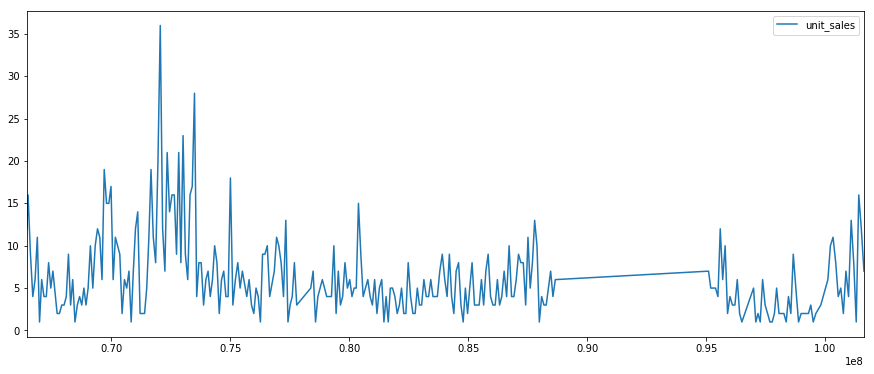

In [12]:
train_2016_25_105574.plot(figsize=(15, 6))
plt.show()

We can see there are some data which are not here . 

In [13]:
df_date=pd.DataFrame(date_list)
df_date = df_date.rename(columns={0: 'date'})
df_date.head()

,date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [14]:
df = pd.merge(df_date, train_2016_25_105574, how='left', on=['date'])
df.fillna(0,inplace=True)

df.head()

,date,unit_sales
0,2016-01-01,12.0
1,2016-01-02,16.0
2,2016-01-03,9.0
3,2016-01-04,4.0
4,2016-01-05,6.0


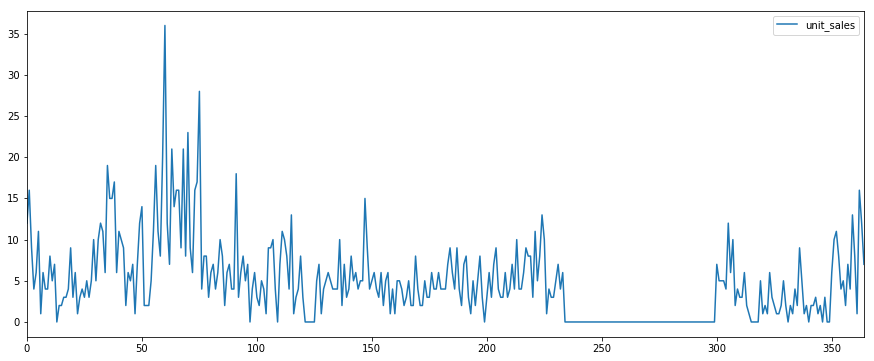

,unit_sales
count,365.000000
mean,4.819178
std,4.921378
min,0.000000
25%,1.000000
50%,4.000000
75%,7.000000
max,36.000000


In [15]:
df.plot(figsize=(15, 6))
plt.show()
df.describe()

## LSTM

In [16]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [17]:
# fix random seed for reproducibility
numpy.random.seed(7)




In [18]:
# split into train and test sets
train, test =df[df["date"].dt.month <= 11], df[df["date"].dt.month > 11]
train=train.set_index("date")
test=test.set_index("date")
df=df.set_index("date")
train=train.values
test=test.values
df=df.values


In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [21]:

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(testX, testY),epochs=25, batch_size=1, verbose=2)

Train on 330 samples, validate on 25 samples
Epoch 1/25
1s - loss: 38.1932 - val_loss: 27.5576
Epoch 2/25
1s - loss: 23.8119 - val_loss: 19.2611
Epoch 3/25
1s - loss: 19.8743 - val_loss: 18.8944
Epoch 4/25
1s - loss: 18.6536 - val_loss: 19.7716
Epoch 5/25
1s - loss: 18.9382 - val_loss: 19.9046
Epoch 6/25
1s - loss: 18.2721 - val_loss: 20.2348
Epoch 7/25
1s - loss: 16.7816 - val_loss: 20.3805
Epoch 8/25
1s - loss: 17.2182 - val_loss: 20.3342
Epoch 9/25
1s - loss: 16.3994 - val_loss: 20.6664
Epoch 10/25
1s - loss: 15.8535 - val_loss: 20.8287
Epoch 11/25
1s - loss: 15.1631 - val_loss: 20.6270
Epoch 12/25
1s - loss: 15.0002 - val_loss: 20.4670
Epoch 13/25
1s - loss: 14.4929 - val_loss: 20.8857
Epoch 14/25
1s - loss: 16.0005 - val_loss: 20.8699
Epoch 15/25
1s - loss: 15.2334 - val_loss: 20.6376
Epoch 16/25
1s - loss: 15.5908 - val_loss: 21.3359
Epoch 17/25
1s - loss: 14.5024 - val_loss: 21.5392
Epoch 18/25
1s - loss: 14.2528 - val_loss: 20.5694
Epoch 19/25
1s - loss: 15.2458 - val_loss: 21.

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

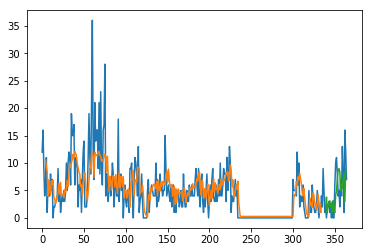

In [24]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions

plt.plot(df)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [25]:
result=pd.DataFrame(testPredict)
result["testY"]=testY
result

,0,testY
0,1.819726,2.0
1,3.797086,0.0
2,0.919335,2.0
3,2.302592,2.0
4,2.945876,3.0
5,3.097588,1.0
6,2.073555,2.0
7,2.665918,0.0
8,1.046624,3.0
9,3.151656,0.0
